In [39]:
# !pip install -U httpcore httpx

In [40]:
import pandas as pd
from urllib.parse import urlparse
from bs4 import BeautifulSoup
import requests
import numpy as np
import time
from unidecode import unidecode
import os
import matplotlib.pyplot as plt
from langdetect import detect
from googletrans import Translator
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
import regex as re
import newspaper
import math
import PyPDF2
from pdfminer.high_level import extract_text
import json

data = pd.read_excel('combined.xlsx')

data.head()

,Date,Source,Headline,Translated.headline,Manual.summary,Original.article.url,Media.type,Speaker,Reach,Language,Country.Code,Sitename,Tags,Site_Readership,Article_Readership
0,2022-09-30 22:08:34,Il Messaggero - Borsa Italiana,"Visco: «Troppi rialzi dei tassi, si va in rece...","Banca d'Italia's Visco: ""Too many rate hikes w...","At a conference in Florence, Banca d'Italia Go...",https://www.ilmessaggero.it/economia/news/tass...,WEB,Newspapers,1174293,it,IT,Il Messaggero,"European Central Bank, European Monetary Union...",2296944.0,0.0
1,2022-09-30 21:44:15,Puls Biznesu - Z ostatniej chwili,Knot: kolejne podwyżki stóp EBC są konieczne,Knot: further ECB rate hikes are necessary,NaN,https://www.pb.pl/knot-kolejne-podwyzki-stop-e...,WEB,Newspapers,72409,pl,PL,Puls Biznesu,"European Central Bank, Inflation, Rank 2, Inte...",73998.0,0.0
2,2022-09-30 21:30:13,Handelsblatt - Finanzen,EZB-Ratsmitglied Visco: Rezessionsrisiko bei g...,ECB 's Visco: Recession risk in the event of m...,Banca d'Italia Governor Ignazio Visco on Fri...,https://www.handelsblatt.com/finanzen/geldpoli...,WEB,Newspapers,525924,de,DE,Handelsblatt,"European Central Bank, European Monetary Union...",314148.0,811493.0
3,2022-09-30 21:07:32,Trend - Správy,ECB by mala byť pri zvyšovaní sadzieb opatrná...,"ECB should be cautious about rate hikes, says...",NaN,https://www.trend.sk/spravy/ecb-mala-byt-pri-z...,WEB,Net Magazine,51466,sk,SK,Trend,"European Central Bank, Inflation, Rank 2, Inte...",53064.0,0.0
4,2022-09-30 20:56:08,Bloomberg - GNews,ECB 's Schnabel Says Weaker Demand May Not Eas...,ECB 's Schnabel says weaker demand may not eas...,ECB Executive Board Member Isabel Schnabel ...,https://www.bloomberg.com/news/articles/2022-0...,WEB,Net Magazine,2520979,en,US,Bloomberg,"European Central Bank, Inflation, Rank 1, Core...",1309524.0,278016.0


## Functions

In [41]:
# Add the base website for URL
def extract_base_url(url):
    parsed_url = urlparse(url)
    return f"{parsed_url.scheme}://{parsed_url.netloc}"

# Function to translate text to English
def translate_to_english(text):
    translator = Translator()
    
    # Check if text length is less than 5000 characters
    if len(text) <= 5000:
        try:
            translated = translator.translate(text, dest='en')
            return translated.text
        except Exception as e:
            print("Translation error:", e)
            return "Translation error"
    else:
        # Split text into smaller chunks
        num_chunks = len(text) // 5000 + 1
        chunks = [text[i*5000:(i+1)*5000] for i in range(num_chunks)]
        
        # Translate each chunk and concatenate the translations
        translated_text = ""
        for chunk in chunks:
            try:
                translated = translator.translate(chunk, dest='en')
                translated_text += translated.text + " "
            except Exception as e:
                print("Translation error:", e)
                return "Translation error"
        
        return translated_text.strip()

def translate_greek_to_english(text):
    translator = Translator()
    translated_text = translator.translate(text, src='el', dest='en')
    return translated_text.text

def split_text(text, num_segments):
    # Calculate the length of each segment
    segment_length = math.ceil(len(text) / num_segments)
    # Split the text into segments
    segments = [text[i:i+segment_length] for i in range(0, len(text), segment_length)]
    return segments

def translate_segments(segments):
    translated_segments = []
    for segment in segments:
        translated_segment = translate_greek_to_english(segment)
        translated_segments.append(translated_segment)
    return translated_segments

def combine_segments(segments):
    return ''.join(segments)

In [42]:
# Get the 45 most common website that we will use to scrape
data['Website'] = data['Original.article.url'].apply(extract_base_url)
data['Website'].value_counts().head(45)

Website
https://paper.opoint.com               10931
http://external.opoint.com              1272
https://www.bloomberg.com               1054
https://www.reuters.com                  983
https://www.handelsblatt.com             696
https://www.finanzen.ch                  517
https://www.di.se                        476
https://www.boersen-zeitung.de           450
https://www.milanofinanza.it             398
https://www.lavanguardia.com             394
https://www.lainformacion.com            364
https://www.expansion.com                342
https://finanza.lastampa.it              337
https://www.europapress.es               328
https://borsen.dk                        327
https://www.ilsole24ore.com              324
https://www.ansa.it                      321
http://www.eleconomista.es               304
https://www.jornaldenegocios.pt          300
https://expresso.pt                      287
https://www.bankingnews.gr               286
https://www.euro2day.gr                  285
ht

# Scraping
We decided to scrape the most common websites to get the most amount of full articles to work with
## Problems
#### bloomberg.com is payed
#### handlesblatt.de doesn't work
#### ilsusidiario.net doesnt't work
#### di.se is payed or don't show anything
#### boersen-zeitung.de is payed
#### expansion.com is payed
#### borsen.dk is payed
#### jornaldenegocios.pt is payed
#### borsa.corriere.it links don't work
#### repubblica.it is payed
___

### For reuters.com links

In [43]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('reuters.com')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        time.sleep(3)
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            # text = soup.find('div', class_='article-body')
            # print(text)

            # Find all paragraph elements with data-testid starting with 'paragraph-'
            paragraphs = soup.find_all(lambda tag: tag.name == 'div' and tag.get('data-testid', '').startswith('paragraph-'))

            # Extract text from each paragraph and print
            text = ""
            for paragraph in paragraphs:
                paragraph_text = paragraph.text.strip()
                text += paragraph_text + "\n"
        
        except: text = np.nan

        try: text = unidecode(text)
        except: 
            text = np.nan
        print(text)
        urls.append(URL)
        texts.append(text)

    df = pd.DataFrame({'url': urls, 'text': texts})
    df.to_csv("Scraped/reuters.com.csv", index=False)


Sept 30 (Reuters) - Euro zone debt yields fell on Friday after a sharp bond selloff earlier this week but anxiety persisted about central banks' monetary tightening path and possible erratic moves in UK gilts.
Yields fell even as euro zone inflation zoomed past forecasts to hit 10.0% in September, a new record high, as expected by analysts after German data showed consumer prices increased by 10.9% over the year.
Following a surge triggered by British Prime Minister Liz Truss' controversial plan to reignite economic growth with tax cuts, British government bond markets have relatively calmed since the Bank of England announced bond purchases on Wednesday to ease market stress. Investors said they'd still wait for a credible plan to keep debt under control.
In the euro zone bond market, which has been hit by the UK-driven volatility, by 1512 GMT, Germany's 10-year government bond yield was down 9 basis points (bps) at 2.12%, considerably below the highest since December 2011 it touched 

### For finanzen.ch links

In [44]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('finanzen.ch')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            text = soup.find('div', class_='grid__col--12 instrument-description')

            # Extract text and split paragraphs
            paragraphs = [p.get_text(strip=True) for p in text.find_all('p')]

            # Combine paragraphs into a single text with breaks
            text = '\n'.join(paragraphs)
        
        except: text = np.nan

        try: text = unidecode(text)
        except: 
            text = np.nan
        urls.append(URL)
        texts.append(text)

    # Concatenate df with the new scraped data
    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/finanzen.ch.csv", index=False)
    

### For milanofinanza.it links

In [45]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('milanofinanza.it')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            text = soup.find('div', class_='newsContent corpo-articolo clearfix').text.strip()
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/milanofinanza.it.csv", index=False)

### For lavanguardia.com links

In [46]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('lavanguardia.com')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', class_='article-modules').find_all('p')

            text = ""
            for paragraph in a_tag:
                paragraph_text = paragraph.text
                text += paragraph_text + "\n"
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/lavanguardia.com.csv", index=False)

### For lainformacion.com links

In [47]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('lainformacion.com')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', class_='article-text').find_all(class_='paragraph')
    
            text = ""
            for paragraph in a_tag:
                paragraph_text = paragraph.text.strip()
                text += paragraph_text + "\n"
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/lainformacion.com.csv", index=False)
    

### For finanza.lastampa.it links (No Paragraphs!!)

In [48]:
# if __name__ == '__main__':

#     # add your user agent 
#     HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

#     # The base webpage URL
#     url_list = data[data['Website'].str.contains('finanza.lastampa.it')]['Original.article.url'].to_list()
    
#     urls = []
#     texts = []

#     for URL in url_list:
#         try:
#             # HTTP Request
#             webpage = requests.get(URL, headers=HEADERS)

#             # Soup Object containing all data
#             soup = BeautifulSoup(webpage.content, "html.parser")
#             a_tag = soup.find('div', class_='testoNews').find('div', class_="text-container")

#             text = ''

#             # Iterate through the contents of the <p> tag
#             for content in a_tag.contents:
#                 # Check if the content is a <strong> tag
#                 if content.name == "strong":
#                     # If it's a <strong> tag, iterate through its contents
#                     for inner_content in content.contents:
#                         # Check if the inner content is a <br/> tag
#                         if inner_content.name == "br":
#                             # If it's a <br/> tag, add a newline character
#                             text += "\n"
#                         else:
#                             # If it's text or another tag, add its text content
#                             text += str(inner_content)
#                 else:
#                     # If it's not a <strong> tag, handle it as before
#                     if content.name == "br":
#                         # If it's a <br/> tag, add a newline character
#                         text += "\n"
#                     else:
#                         # If it's text or another tag, add its text content
#                         text += str(content.text)
        
#         except: text = np.nan

#         try: text = unidecode(text)
#         except:
#             text = np.nan
#         urls.append(URL)
#         texts.append(text)

#     df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    # pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/finanza.lastampa.it.csv", index=False)

### For europapress.es links

In [49]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('europapress.es')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            text = soup.find('div', class_='NormalTextoNoticia').text.strip()
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/europapress.es.csv", index=False)

### For ilsole24ore.com links

In [50]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('ilsole24ore.com')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', class_='col-lg-10').find_all(class_='atext')

            text = ""
            for paragraph in a_tag:
                paragraph_text = paragraph.text.strip()
                text += paragraph_text + "\n"
                
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/ilsole24ore.com.csv", index=False)

### For ansa.it links (No Paragraphs!!)

In [51]:
# if __name__ == '__main__':

#     # add your user agent 
#     HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

#     # The base webpage URL
#     url_list = data[data['Website'].str.contains('ansa.it')]['Original.article.url'].to_list()
    
#     urls = []
#     texts = []

#     for URL in url_list:
#         try:
#             # HTTP Request
#             webpage = requests.get(URL, headers=HEADERS)

#             # Soup Object containing all data
#             soup = BeautifulSoup(webpage.content, "html.parser")
#             try: text = soup.find('div', class_='post-single-text rich-text').text.strip()
#             except: 
#                 try: text = soup.find('div', class_='news-txt').text.strip()
#                 except: text = soup.find('div', class_='corpo').text.strip()
        
#         except: text = np.nan

#         try: text = unidecode(text)
#         except:
#             text = np.nan
#         urls.append(URL)
#         texts.append(text)

#     df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    # pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/ansa.it.csv", index=False)

### For eleconomista.es links

In [52]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('eleconomista.es')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', class_='Article__paragraphGroup col-lg-10 col-md-12 col-12').find_all('p')

            text = ""
            for paragraph in a_tag:
                paragraph_text = paragraph.text.strip()
                text += paragraph_text + "\n"
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/eleconomista.es.csv", index=False)

### For expresso.pt links

In [53]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('expresso.pt')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', class_='full-article-fragment full-article-body article-content first').find_all('p')

            text = ""
            for paragraph in a_tag:
                paragraph_text = paragraph.text.strip()
                text += paragraph_text + "\n"
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/expresso.pt.csv", index=False) 

### For bankingnews.gr links

In [54]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('bankingnews.gr')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            try: a_tag = soup.find('div', class_='itemFullText').find('p')
            except: a_tag = soup.find('div', class_='itemFullText')

            text = ""

            # Iterate through the contents of the <p> tag
            for content in a_tag.contents:
                # Check if the content is a <br/> tag
                if content.name == "br":
                    # If it's a <br/> tag, add a newline character
                    text += "\n"
                else:
                    # If it's text or another tag, add its text content
                    text += str(content.text)

            segments = split_text(text, 3)

            # Translate each segment
            translated_segments = translate_segments(segments)

            # Combine the translated segments
            text = combine_segments(translated_segments)
            cleaned_text = re.sub(r'\n(?!\n)', ' ', text)
            text = re.sub(r'\n{2,}', '\n', cleaned_text)
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/bankingnews.gr.csv", index=False)

### For euro2day.gr links

In [55]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('euro2day.gr')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', class_='col-lg-10 col-md-11 article-sticky-container').find(class_='mt10').find_all('p')

            text = ""
            for paragraph in a_tag:
                paragraph_text = paragraph.text.strip()
                text += paragraph_text + "\n"

            segments = split_text(text, 3)

            # Translate each segment
            translated_segments = translate_segments(segments)

            # Combine the translated segments
            text = combine_segments(translated_segments)
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/euro2day.gr.csv", index=False)

### For capital.gr links

In [56]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('capital.gr')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', id='articleBody').find_all('p')
            text = ''
            for paragraph in a_tag:
                paragraph_text = paragraph.text.strip()
                text += paragraph_text + "\n"
            segments = split_text(text, 3)

            # Translate each segment
            translated_segments = translate_segments(segments)

            # Combine the translated segments
            text = combine_segments(translated_segments)
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/capital.gr.csv", index=False)

Μια αύξηση των επιτοκίων κατά 100 μονάδες βάσης από την Ευρωπαϊκή Κεντρική Τράπεζα θα ήταν "πολύ, αυτή την στιγμή", εκτίμησε το μέλος του Δ.Σ. της τράπεζας και διοικητής της κεντρικής τράπεζας της Αυστρίας, Ρόμπερτ Χόλτσμαν, ο οποίος περιμένει μια αύξηση κατά 75 μονάδες.
"Οι 50 [μονάδες] μπορεί να είναι το ελάχιστο" στη συνεδρίαση του Οκτωβρίου για τα επιτόκια, δήλωσε ο Χόλτσμαν μιλώντας στο Bloomberg. "Θα μπορούσε να είναι 100; Θα μπορούσε, αλλά δεν βλέπω την ανάγκη τώρα να πάμε τόσο γρήγορα. Νομίζω ότι οι 75 μονάδες θα είναι μια καλή υπόθεση", πρόσθεσε.
Ο αξιωματούχος σημείωσε πάντως ότι η ΕΚΤ έχει ακόμα "κάποιο δρόμο" μέχρι το ουδέτερο επιτόκιο, το οποίο ούτε τονώνει αλλά ούτε περιορίζει την οικονομική δραστηριότητα. Σημείωσε ότι το να φτάσει το επιτόκιο των καταθέσεων στο 2,5% από 0,75% που είναι σήμερα, σίγουρα θα το οδηγούσε πέρα από το ουδέτερο.
Σημείωσε επίσης ότι η συρρίκνωση του χαρτοφυλακίου των ομολόγων που η ΕΚΤ συγκέντρωσε τα προηγούμενα χρόνια αποτελεί μέρος της διαδικασ

### For cincodias.elpais.com links

In [57]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('cincodias.elpais.com')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', class_='a_c clearfix').find_all('p')

            text = ""
            for paragraph in a_tag:
                paragraph_text = paragraph.text.strip()
                text += paragraph_text + "\n"
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/cincodias.elpais.com.csv", index=False)

### For investor.bg links

In [58]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('investor.bg')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', class_='article-content')
            b_tag = soup.find('div', class_='article-content').find(class_='related-articles')

            # Find all <p> tags that are not within the related articles div
            paragraphs_a = a_tag.find_all('p', recursive=False)

            all_paragraphs_text = ""
            for paragraph in paragraphs_a:
                all_paragraphs_text += paragraph.text.strip() + "\n"

            cleaned_text = '\n'.join(line for line in b_tag.text.strip().splitlines() if line.strip())

            # Split both texts into lines
            lines_a = all_paragraphs_text.splitlines()
            lines_b = cleaned_text.splitlines()

            # Find lines only in text_a while preserving order
            remaining_lines = [line for line in lines_a if line not in lines_b]

            # Join the remaining lines back into a string
            text = '\n'.join(remaining_lines)
            text = translate_to_english(text)
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/investor.bg.csv", index=False)

### For finanza.tgcom24.mediaset.it links

In [59]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('finanza.tgcom24.mediaset.it')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            text = soup.find('div', class_='floatL w515 pleft5 t2 pT20').text.strip()
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)
        break

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/finanza.tgcom24.mediaset.it.csv", index=False)

### For bfmtv.com links

In [60]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('bfmtv.com')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', class_='content_description')

            if a_tag is None:
                a_tag = soup.find('div', class_='content_body').find_all('p')

                text = ''
                for paragraph in a_tag:
                    paragraph_text = paragraph.text.strip()
                    text += paragraph_text + "\n"

            else:
                text = a_tag.text.strip()
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/bfmtv.com.csv", index=False, encoding='utf-8')

### For faz.net links (Payed)

In [61]:
# if __name__ == '__main__':

#     # add your user agent 
#     HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

#     # The base webpage URL
#     url_list = data[data['Website'].str.contains('faz.net')]['Original.article.url'].to_list()
    
#     urls = []
#     texts = []

#     for URL in url_list:
#         try:
#             # HTTP Request
#             webpage = requests.get(URL, headers=HEADERS)

#             # Soup Object containing all data
#             soup = BeautifulSoup(webpage.content, "html.parser")
#             a_tag = soup.find('article', class_='article')

#             script_tag = a_tag.find('script', type='application/ld+json')

#             if script_tag:
#                 # Extract the JSON data from the <script> tag
#                 json_data = script_tag.string
                
#                 # Parse the JSON data
#                 parsed_data = json.loads(json_data)
                
#                 # Extract the value corresponding to the "articleBody" key
#                 text = parsed_data.get("articleBody", "")
        
#         except: text = np.nan

#         try: text = unidecode(text)
#         except:
#             text = np.nan
#         urls.append(URL)
#         texts.append(text)

#     df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    # pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/faz.net.csv", index=False)

### For elconfidencial.com links

In [62]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('elconfidencial.com')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            text = soup.find('div', class_='newsType__content').text.strip()
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/elconfidencial.com.csv", index=False)

### For challenges.fr links

In [63]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('challenges.fr')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            text = soup.find('div', class_='corps').text.strip()
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/challenges.fr.csv", index=False)

### For affaritaliani.it links

In [64]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('affaritaliani.it')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            try: text = soup.find('div', class_='cnt-body').text.strip()
            except: text = soup.find('div', itemprop='articleBody').text.strip()
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/affaritaliani.it.csv", index=False)

### For ilgiornale.it links

In [65]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('ilgiornale.it')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            text = soup.find('div', class_='content__body').text.strip()
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/ilgiornale.it.csv", index=False)

### For abc.es links

In [66]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('abc.es')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', class_='voc-d').find_all(class_='voc-p')

            text = ""
            for paragraph in a_tag:
                paragraph_text = paragraph.text.strip()
                text += paragraph_text + "\n"
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/abc.es.csv", index=False)

### For wiwo.de links

In [67]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('wiwo.de')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', class_='o-article__content').find_all(class_='o-article__content-element')

            text = ""
            for paragraph in a_tag:
                paragraph_text = paragraph.text.strip()
                text += paragraph_text + "\n"
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/wiwo.de.csv", index=False)

### For jornaleconomico.pt links

In [68]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('jornaleconomico.pt')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', class_='uk-panel uk-margin').find_all('p')

            text = ""
            for paragraph in a_tag:
                paragraph_text = paragraph.text.strip()
                text += paragraph_text + "\n"
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/jornaleconomico.pt.csv", index=False)

### For lesechos.fr links

In [69]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('lesechos.fr')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', class_='sc-1s859o0-0').find_all(class_='sc-nmm9yg-6 dTerhx')
            b_tag = soup.find('div', class_='sc-1s859o0-0').find_all(class_='sc-nlqesd-4 cqTuwL')

            paragraphs_a = ""
            for paragraph in a_tag:
                paragraphs_a = paragraphs_a + paragraph.text.strip() + '\n'

            paragraphs_b = ""
            for paragraph in b_tag:
                paragraphs_b = paragraphs_b + paragraph.text.strip() + '\n'
            paragraphs_b = paragraphs_b.replace("Lire aussi\xa0:", "")

            # Split both texts into lines
            lines_a = paragraphs_a.splitlines()
            lines_b = paragraphs_b.splitlines()

            # Convert lists to sets for faster comparison
            set_a = set(lines_a)
            set_b = set(lines_b)

            # Find the set difference to get lines only in text_a
            remaining_lines = [line for line in lines_a if line not in set_b]

            # Join the remaining lines back into a string
            text = '\n'.join(remaining_lines)
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/lesechos.fr.csv", index=False)

### For press.ruepointmedia.com links

In [93]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('press.ruepointmedia.com')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', class_='container').find('p').text.strip()
        
        except: text = np.nan

        try: text = unidecode(a_tag)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/press.ruepointmedia.com.csv", index=False)

### For elpais.com links

In [71]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('/elpais.com')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', class_='a_c').find_all('p')
            
            text = ""
            for paragraph in a_tag:
                if paragraph == a_tag[-1]:
                    continue
                paragraph_text = paragraph.text.strip()
                text += paragraph_text + "\n"
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/elpais.com.csv", index=False)

### For trend.sk links

In [72]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; ru) Opera 8.0', 'Accept-Language': 'en-US, en;q=0.5'})

    # The base webpage URL
    url_list = data[data['Website'].str.contains('trend.sk')]['Original.article.url'].to_list()
    
    urls = []
    texts = []

    for URL in url_list:
        try:
            # HTTP Request
            webpage = requests.get(URL, headers=HEADERS)

            # Soup Object containing all data
            soup = BeautifulSoup(webpage.content, "html.parser")
            a_tag = soup.find('div', class_='article-body').find_all('p')

            text = ""
            for paragraph in a_tag:
                paragraph_text = paragraph.text.strip()
                text += paragraph_text + "\n"
        
        except: text = np.nan

        try: text = unidecode(text)
        except:
            text = np.nan
        urls.append(URL)
        texts.append(text)

    df = pd.concat([df, pd.DataFrame({'url': urls, 'text': texts})])
    pd.DataFrame({'url': urls, 'text': texts}).to_csv("Scraped/trend.sk.csv", index=False)

### Putting all the scraping together

In [158]:
# # Directory containing CSV files
# folder_path = 'Scraped/'
# # List to store individual DataFrames
# dfs = []

# # Iterate over each file in the directory
# for filename in os.listdir(folder_path):
#     if filename.endswith('.csv'):
#         # Construct the full file path
#         file_path = os.path.join(folder_path, filename)
#         # Read the CSV file into a DataFrame
#         df = pd.read_csv(file_path)
#         # Append the DataFrame to the list
#         dfs.append(df)

# # Concatenate all DataFrames into one
# total_scraped_manual = pd.concat(dfs, ignore_index=True)
total_scraped_manual = df.copy()
total_scraped_manual = total_scraped_manual[total_scraped_manual['text']!='']
total_scraped_manual.dropna(inplace=True)

# Treat illegal characters
# total_scraped_manual = total_scraped_manual.map(lambda x: x.encode('unicode_escape').
#                 decode('utf-8') if isinstance(x, str) else x)
# Create a new column with the base website URL
total_scraped_manual['Website'] = total_scraped_manual['url'].apply(extract_base_url)
total_scraped_manual.reset_index(inplace=True)

# Display the combined DataFrame
print(total_scraped_manual.shape)
total_scraped_manual.head()

(5030, 4)


,index,url,text,Website
0,0,https://www.reuters.com/markets/europe/euro-zo...,Sept 30 (Reuters) - Euro zone debt yields fell...,https://www.reuters.com
1,1,https://www.reuters.com/markets/europe/ecbs-la...,"CLEVELAND, Sept 29 (Reuters) - European Centra...",https://www.reuters.com
2,2,https://www.reuters.com/markets/europe/french-...,"PARIS, Sept 29 (Reuters) - Belgian motorists a...",https://www.reuters.com
3,3,https://www.reuters.com/article/ecb-policy-ita...,"FRANKFURT, Sept 29 (Reuters) - European Centra...",https://www.reuters.com
4,4,https://www.reuters.com/article/ecb-policy-sim...,"VILNIUS/FRANKFURT, Sept 29 (Reuters) - ECB pol...",https://www.reuters.com


### Translating the scraped text

In [160]:
indices_to_drop = []  # List to store indices of rows to drop

for index, row in total_scraped_manual.iterrows():
    text_value = row['text']
    url_value = row['url']
    if text_value is not None and isinstance(text_value, str) and text_value.strip() != '':
        try:
            detect(text_value)
        except Exception as e:
            print(f"Error detected at index {index}: '{url_value} and {text_value}', Error: {e}")
            indices_to_drop.append(index)

# Drop rows with indices where exceptions occurred
total_scraped_manual = total_scraped_manual.drop(indices_to_drop)

Error detected at index 4122: 'https://www.bfmtv.com/economie/replay-emissions/good-morning-business/francois-villeroy-de-galhau-gouverneur-de-la-banque-de-france-06-09_EN-202309060271.html and 11:22
', Error: No features in text.
Error detected at index 4126: 'https://www.bfmtv.com/economie/replay-emissions/good-morning-business/patrice-gautry-chef-economiste-de-l-union-bancaire-privee-02-08_EN-202308020104.html and 7:31
', Error: No features in text.
Error detected at index 4160: 'https://www.bfmtv.com/economie/replay-emissions/good-evening-business/jean-claude-trichet-ancien-president-de-la-bce-26-10_EN-202310260852.html and 18:08
', Error: No features in text.
Error detected at index 4164: 'https://www.bfmtv.com/economie/replay-emissions/bfm-bourse/l-eco-du-monde-la-bce-maintient-ses-taux-une-premiere-depuis-16-mois-26-10_EN-202310260626.html and 10:59
', Error: No features in text.
Error detected at index 4179: 'https://www.bfmtv.com/economie/replay-emissions/les-experts/l-integra

In [162]:
# Get the language of the scraped text
total_scraped_manual['Form'] = 'Manually'
total_scraped_manual = total_scraped_manual.drop_duplicates(subset='url', keep='first')

total_scraped_manual['language'] = total_scraped_manual['text'].apply(lambda x: detect(x) if x.strip() != '' else '')
total_scraped_manual['length'] = total_scraped_manual['text'].apply(lambda x: len(x))

print(total_scraped_manual.shape)

(5025, 7)


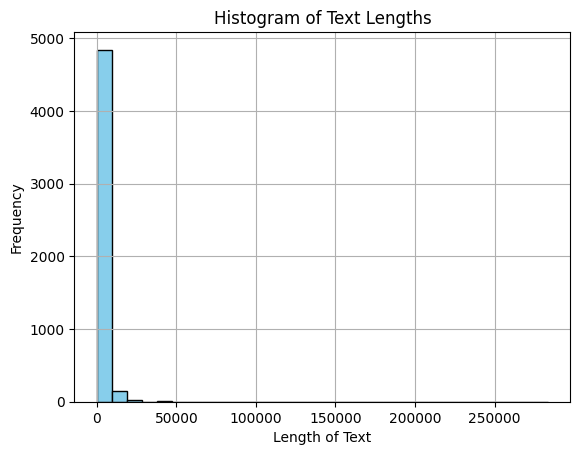

In [163]:
# Plot histogram of the length
plt.hist(total_scraped_manual['length'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths')
plt.grid(True)
plt.show()

In [182]:
# Translating all the text that's not in english to english
# Got rid of texts that were too long because of capacity
total_scraped_manual = total_scraped_manual[total_scraped_manual['length']<30000]

# Assuming 'text_column' is the name of the column containing text in different languages
total_scraped_manual['translated_text'] = np.where(total_scraped_manual['language']!='en', total_scraped_manual['text'].apply(translate_to_english), total_scraped_manual['text'])
total_scraped_manual.to_csv('Translated/total_scraped_manual.csv', index=False)

## Exploring a little of the scraped data

In [178]:
# total_manual = pd.read_csv('Translated/total_scraped_manual.csv')
total_manual = total_scraped_manual.copy()
total_manual.head()

,index,url,text,Website,Form,language,length,translated_text
0,0,https://www.reuters.com/markets/europe/euro-zo...,Sept 30 (Reuters) - Euro zone debt yields fell...,https://www.reuters.com,Manually,en,2881,Sept 30 (Reuters) - Euro zone debt yields fell...
1,1,https://www.reuters.com/markets/europe/ecbs-la...,"CLEVELAND, Sept 29 (Reuters) - European Centra...",https://www.reuters.com,Manually,en,582,"CLEVELAND, Sept 29 (Reuters) - European Centra..."
2,2,https://www.reuters.com/markets/europe/french-...,"PARIS, Sept 29 (Reuters) - Belgian motorists a...",https://www.reuters.com,Manually,en,4718,"PARIS, Sept 29 (Reuters) - Belgian motorists a..."
3,3,https://www.reuters.com/article/ecb-policy-ita...,"FRANKFURT, Sept 29 (Reuters) - European Centra...",https://www.reuters.com,Manually,en,2984,"FRANKFURT, Sept 29 (Reuters) - European Centra..."
4,4,https://www.reuters.com/article/ecb-policy-sim...,"VILNIUS/FRANKFURT, Sept 29 (Reuters) - ECB pol...",https://www.reuters.com,Manually,en,4007,"VILNIUS/FRANKFURT, Sept 29 (Reuters) - ECB pol..."


In [181]:
# Print the text in the first row of total_manual
print(total_manual['translated_text'].iloc[1000])

Latest news


 





Collapse of returns after the ECB decision.At 16h33 the prices of the Eurozone state government bonds deal with firm rise, after the European Central Bank made the decision to increase the reference rates, of 25 basis points.Tenal BTP which therefore records an interest rate equal to 4.36%, as many as 10 base points less, compared to the closing data of yesterday.Question in strong growth also for Bund at ten years, whose financing cost stands at 2.61%.Also the downloading spread, at 175 basis points.At 14h15 of the day today the decision by the ECB to increase the rates of a quarter of a percentage point, thus bringing the rate on the main refinancing to 4.50%, the one on deposits to 4% (the historical maximum), eThe one on marginal loans at 4.75 percent.In any case, an easily predictable decision would not have been according to analysts, however, the fears expressed in the last few days, according to which the market was taking a break for granted, proved to be 

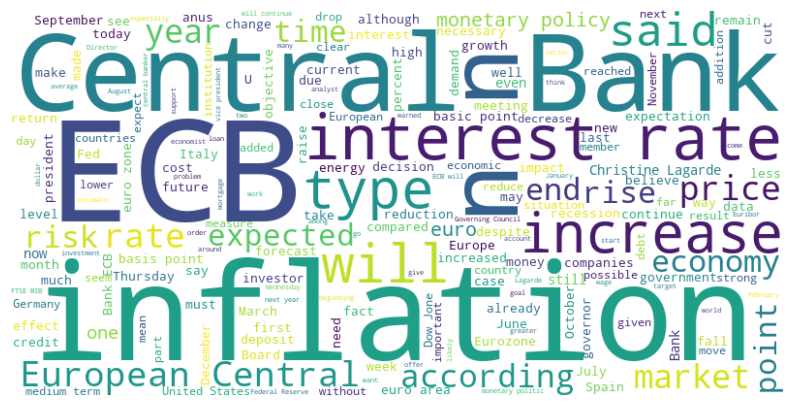

In [116]:
# Combine all text into a single string
text = ' '.join(total_manual['translated_text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Let's get the most common words

In [ ]:
# Download the stopwords corpus if you haven't already
nltk.download('stopwords')

# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Combine all non-null text into a single string and replace \n with spaces
text = ' '.join(total_manual['translated_text'].dropna().astype(str)).replace('\n', ' ')

# Use regex to remove non-alphanumeric characters, numbers, and split into words
words = re.findall(r'\b[A-Za-z]{2,}\b', text.lower())

# Remove stopwords from the list of words
filtered_words = [word for word in words if word not in stop_words]

# Count the occurrences of each word
word_counts = Counter(filtered_words)

# Get the top 20 most common words
top_30_words = word_counts.most_common(30)

# Print the top 20 most common words
print(top_30_words)

In [ ]:
# Get the top 20 most common words that seem relevant
top_words = [word[0] for word in top_30_words if word[0] not in ['also', 'would', 'de', 'last', 'one', 'new', 'types']]
top_words

In [ ]:
# Function to count occurrences of top words in text
def count_top_words(text):
    if pd.isnull(text):
        return 0
    # Tokenize the text into words
    words = re.findall(r'\b[A-Za-z]+\b', text.lower())
    # Count occurrences of top words in the text
    count = sum(1 for word in words if word in top_words)
    return count

# Create a new column in the DataFrame to store the count of top words
total_manual['top_words_count'] = total_manual['translated_text'].apply(count_top_words)

# Display the DataFrame with the new column
total_manual.head()

In [ ]:
# Plot histogram of the top_words_count
plt.hist(total_manual['top_words_count'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Top words count in text')
plt.ylabel('Frequency')
plt.title('Histogram of Top words count in text')
plt.grid(True)
plt.show()

In [ ]:
total_manual.head()

To make sure that the articles scrapped are good for our analysis, we will only use those that have at least 4 words of the most common list

In [ ]:
print(total_manual[total_manual['top_words_count'] < 4]['Website'].value_counts())
# Remove rows with top_words_count less than 4
total_manual = total_manual[total_manual['top_words_count'] >= 4]
total_manual.drop(columns=['text', 'language', 'length'], inplace=True)

### For pdf links (paper.opoint.com)

#### Download all pdf files

In [ ]:
def check_link_type(url):
    # Parse the URL
    parsed_url = urlparse(url)
    
    # Check if the URL path contains '/pdf/' or '.pdf'
    if '/pdf/' in parsed_url.path or parsed_url.path.endswith('.pdf'):
        return 'PDF'
    
    # Send a HEAD request to check Content-Type header
    try:
        response = requests.head(url)
        content_type = response.headers.get('Content-Type', '')
        if 'application/pdf' in content_type:
            return 'PDF'
        elif 'text/html' in content_type:
            return 'Website'
        else:
            return 'Unknown'
    except requests.exceptions.RequestException as e:
        print("Error:", e)
        return 'Unknown'

def download_pdf(url, folder, filename=None):
    # Send a GET request to download the PDF
    try:
        response = requests.get(url)
        if response.status_code == 200:
            # If filename is not provided, extract it from the URL
            if filename is None:
                filename = os.path.basename(urlparse(url).path)
                # Remove invalid characters from the filename
                filename = "".join(x for x in filename if x.isalnum() or x in ['.', '_', '-'])
            filepath = os.path.join(folder, filename)
            # Save the PDF file
            with open(filepath, 'wb') as f:
                f.write(response.content)
        else:
            print(f"Failed to download {url}")
    except requests.exceptions.RequestException as e:
        print("Error:", e)

# List of URLs to check
url_list = data['Original.article.url'].to_list()

# Folder to save downloaded PDFs
download_folder = 'pdfs'

# Create the download folder if it doesn't exist
if not os.path.exists(download_folder):
    os.makedirs(download_folder)

downloaded_pdfs = []
i = 1
# Iterate over each URL
for url in url_list:
    # Check the link type
    link_type = check_link_type(url)
    if link_type == 'PDF':
        # Download the PDF into the folder
        try: 
            download_pdf(url, download_folder, filename=f'{i}.pdf')
            # Store the URL and PDF number tuple
            downloaded_pdfs.append((url, i))
            i += 1
        except: 
            pass

# Convert the list of tuples into a DataFrame
df_downloaded_pdfs = pd.DataFrame(downloaded_pdfs, columns=['URL', 'PDF_Number'])
df_downloaded_pdfs.to_csv('pdfs/urls_pdfs.csv', index=False)

#### Extract text from pdf using PyPDF2

In [ ]:
def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file."""
    text = ""
    with open(pdf_path, "rb") as f:
        pdf_reader = PyPDF2.PdfReader(f)
        num_pages = len(pdf_reader.pages)
        for page_num in range(num_pages):
            page = pdf_reader.pages[page_num]
            text += page.extract_text().strip()
    return text

# Directory containing PDF files
pdfs_directory = 'pdfs'

# Create an empty dictionary to store the text from the PDFs
urls = []
texts = []

# Iterate over each row in the DataFrame to scrape the pdfs
for index, row in df_downloaded_pdfs.iterrows():
    # Get the URL and PDF number
    url = row['URL']
    pdf_number = row['PDF_Number']
    # Get the full path of the PDF file
    pdf_path = os.path.join(pdfs_directory, f'{pdf_number}.pdf')
    # Extract text from the PDF
    text = extract_text_from_pdf(pdf_path)
    # Translate the extracted text to English in case it's not in English
    try:
        if detect(text) != 'en':
            text = translate_to_english(text)
            text = unidecode(text)
    except: text = np.nan
    # Store the text in the dictionary using the url as the key
    urls.append(url)
    texts.append(text)
    
# Save the URLs and texts to a dataframe
scraped_pdfs_df = pd.DataFrame({'url': urls, 'text': texts})

In [ ]:
# Create a new column in the DataFrame to store the count of top words
scraped_pdfs_df['top_words_count'] = scraped_pdfs_df['text'].apply(count_top_words)

# Display the DataFrame with the new column
scraped_pdfs_df.head()

In [ ]:
# Plot histogram of the top_words_count
plt.hist(scraped_pdfs_df['top_words_count'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Top words count in text')
plt.ylabel('Frequency')
plt.title('Histogram of Top words count in text')
plt.grid(True)
plt.show()

In [ ]:
# Get all the urls that have less than 4 of the top words count
failed_urls = scraped_pdfs_df[scraped_pdfs_df['top_words_count'] < 4]['url'].tolist()

# Get the data frame from df_downloaded_pdfs that are in the pdfs_to_scrape list
pdfs_to_scrape_df2 = df_downloaded_pdfs[df_downloaded_pdfs['URL'].isin(failed_urls)]

#### Extract text from pdf using pdfminer

In [ ]:
def extract_text_from_pdf(pdf_path):
    text = extract_text(pdf_path)
    # Replace line breaks with space
    text = text.replace('\n', ' ')
    return text

# Directory containing PDF files
pdfs_directory = 'pdfs2'

# Create an empty list to store the text from the PDFs
urls = []
texts = []

# Iterate over each row in the DataFrame to scrape the PDFs
for index, row in pdfs_to_scrape_df2.iterrows():
    # Get the PDF number
    url = row['URL']
    pdf_number = row['PDF_Number']
    # Get the full path of the PDF file
    pdf_path = os.path.join(pdfs_directory, f'{pdf_number}.pdf')
    # Extract text from the PDF
    try: text = extract_text_from_pdf(pdf_path)
    except: 
        text = np.nan
    # Translate the extracted text to English in case it's not in English
    try:
        if detect(text) != 'en':
            text = translate_to_english(text)
            text = unidecode(text)
    except: text = np.nan
    # Append the text to the list
    urls.append(url)
    texts.append(text)
    
# Save the texts to a DataFrame along with the URLs
scraped_pdfs_df2 = pd.DataFrame({'url': urls, 'text': texts})

In [ ]:
# Create a new column in the DataFrame to store the count of top words
scraped_pdfs_df2['top_words_count'] = scraped_pdfs_df2['text'].apply(count_top_words)

# Display the DataFrame with the new column
scraped_pdfs_df2.head()

In [ ]:
# Plot histogram of the top_words_count
plt.hist(scraped_pdfs_df2['top_words_count'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Top words count in text')
plt.ylabel('Frequency')
plt.title('Histogram of Top words count in text')
plt.grid(True)
plt.show()

In [ ]:
# Get all the scraped pdfs with a top words count greater than 3
final_pdfs_scraped = pd.concat([scraped_pdfs_df[scraped_pdfs_df['top_words_count'] > 3], scraped_pdfs_df2[scraped_pdfs_df2['top_words_count'] > 3]])
final_pdfs_scraped.shape

In [ ]:
final_pdfs_scraped['translated_text'] = final_pdfs_scraped['text']
final_pdfs_scraped.drop(columns=['text'], inplace=True)
final_pdfs_scraped['Website'] = final_pdfs_scraped['url'].apply(extract_base_url)
final_pdfs_scraped['Form'] = 'Manually'

In [ ]:
# Concatenate total_manual and final_pdfs_scraped
total_manual = pd.concat([total_manual, final_pdfs_scraped], ignore_index=True)
print(total_manual.shape)
print(total_manual.head())

### Use Newspaper3k to extract text from the remaining urls

In [ ]:
url_list_ready = total_manual['url'].tolist()

# Remove all rows from data that have already been scraped
articles_df = data[~data['Original.article.url'].isin(url_list_ready)]

articles_links = articles_df['Original.article.url'].to_list()
languages = articles_df['Language']

articles_data = []
valid_language_codes = ['ar', 'ru', 'nl', 'de', 'en', 'es', 'fr', 'he', 'it', 'ko', 'no', 'fa', 'pl', 'pt', 'sv', 'hu', 'fi', 'da', 'zh', 'id', 'vi', 'sw', 'tr', 'el', 'uk']

for url, lang in zip(articles_links, languages):
    if lang in valid_language_codes:
        article = newspaper.Article(url=url, language = lang)
    else:
        article = newspaper.Article(url=url)
    try:
        article.download()
        article.parse()
        text = str(article.text)
        try:
            if detect(text) != 'en':
                text = translate_to_english(text)
                text = unidecode(text)
        except: text = np.nan

        article_data = {
            "url": url,
            "text": text
        }
        articles_data.append(article_data)
    except Exception as e:
        print(f"Error processing {url}: {e}")
        pass

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(articles_data)
df.to_csv('Newspaper/data_articles.csv')

In [ ]:
df = pd.read_csv('Newspaper/data_articles.csv')
df.head()

In [ ]:
# Replace \n for spaces in text
df['text'] = df['text'].str.replace('\n', ' ')

# Get the language of the scraped text
df['Form'] = 'Newspaper3k'
df = df.drop_duplicates(subset='url', keep='first')
df.dropna(inplace=True)

df['language'] = df['text'].apply(lambda x: detect(x) if x.strip() != '' else '')
df['length'] = df['text'].apply(lambda x: len(x))

print(df.shape)

In [ ]:
# Plot histogram of the length
plt.hist(df['length'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths')
plt.grid(True)
plt.show()

In [ ]:
# Translating all the text that's not in english to english
# Got rid of texts that were too long because of capacity
df = df[df['length']<30000]

# Treat illegal characters
df = df.map(lambda x: x.encode('unicode_escape').
                decode('utf-8') if isinstance(x, str) else x)

# Function to translate text to English
def translate_to_english(text):
    translator = Translator()
    
    # Check if text length is less than 5000 characters
    if len(text) <= 5000:
        try:
            translated = translator.translate(text, dest='en')
            return translated.text
        except Exception as e:
            print("Translation error:", e)
            return None
    else:
        # Split text into smaller chunks
        num_chunks = len(text) // 5000 + 1
        chunks = [text[i*5000:(i+1)*5000] for i in range(num_chunks)]
        
        # Translate each chunk and concatenate the translations
        translated_text = ""
        for chunk in chunks:
            try:
                translated = translator.translate(chunk, dest='en')
                translated_text += translated.text + " "
            except Exception as e:
                print("Translation error:", e)
        
        return translated_text.strip()

# Assuming 'text_column' is the name of the column containing text in different languages
df['translated_text'] = np.where(df['language']!='en', df['text'].apply(translate_to_english), df['text'])

df.to_csv('Translated/translated_newspaper.csv', index=False)

In [ ]:
translated_newspaper = pd.read_csv('Translated/translated_newspaper.csv')
translated_newspaper['Website'] = translated_newspaper['url'].apply(extract_base_url)
translated_newspaper['top_words_count'] = translated_newspaper['translated_text'].dropna().apply(count_top_words)
translated_newspaper.drop(columns=['text', 'language', 'length'], inplace=True)
translated_newspaper.head()

In [ ]:
# Merge the final_df of the manual scraping and translated_newspaper
final_df = pd.concat([total_manual, translated_newspaper], ignore_index=True)
print(final_df.shape)
final_df.head()

In [ ]:
# Filter all the rows that have a top words count less than 4
final_df = final_df[final_df['top_words_count'] >= 4]
final_df.to_excel('final_total_df.xlsx', index=False)